# Transformers Walkthrough
## Author: Brady Lamson

This notebook is intended to showcase a basic workflow for finetuning a transformers LLM for `named entity recognition (NER)`. There are many resources online for this but the information I need for this specific workflow is scattered throughout many sources. As such, I thought to consolidate them into something more digestable. For starters, I'll be pulling a lot of information from the [token classification guide](https://huggingface.co/docs/transformers/tasks/token_classification) and the [hyperparameter search tutorial](https://huggingface.co/docs/transformers/hpo_train) from the huggingface docs.

This notebook on its own won't really be bringing much new to the table. It serves primarily as a companion piece to a more proper writeup that will be hosted on my main site. I won't be including all of my code there so hopefully this notebook will serve as a good reference as you move through the walkthrough.

# The Dataset

We'll be using the [CONLL2003 dataset](https://huggingface.co/datasets/conll2003).

> The shared task of CoNLL-2003 concerns language-independent named entity recognition. We will concentrate on four types of named entities: persons, locations, organizations and names of miscellaneous entities that do not belong to the previous three groups.
> The CoNLL-2003 shared task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. Note the dataset uses IOB2 tagging scheme, whereas the original dataset uses IOB1.

This dataset conveniently contains all of the features I need for this tutorial. Obviously in the real world you'll need to put in a sizable amount of effort to getting labeled data and putting it into this format, but that's outside the scope of this tutorial. I at least hope that by showing what I'm working with and explaining what all the various features represent that this will be a less overwhelming task.

## Loading the Data

We'll be using the huggingface `datasets` library a lot here. It's built specifically for being used with `transformers` and also comes with many datasets we can load in for demonstrations such as this. 

The dataset we'll be loading in has a TON of rows so I'll be cutting the training split in half for demonstration purposes.

In [1]:
from datasets import load_dataset

dataset = load_dataset("conll2003")
dataset["train"] = dataset["train"].train_test_split(test_size=0.5)["train"]
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 7020
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

What we can see here is a `DatasetDict` object. This outside object is fairly straightforward, it's a fancy dictionary that can contain any number of `Dataset` objects. For the sake of this demonstration, these `Datasets` are all different splits, or parts of the whole overall dataset.

Normally you'd need to split your data and load it into a dataset dictionary yourself, so the organization of this object is helpful to develop some familiarity with so you know what you'll be building towards.

First, let's check out an individual row from the training split.

In [2]:
dataset["train"][0]

{'id': '9703',
 'tokens': ['The',
  'Bradys',
  'walked',
  'on',
  'to',
  'the',
  'stage',
  ',',
  'he',
  'on',
  'her',
  'arm',
  'and',
  'with',
  'the',
  'aid',
  'of',
  'a',
  'cane',
  ',',
  'to',
  'a',
  'rousing',
  'reception',
  'from',
  'the',
  'convention',
  '.'],
 'pos_tags': [12,
  23,
  38,
  15,
  35,
  12,
  21,
  6,
  28,
  15,
  29,
  21,
  10,
  15,
  12,
  21,
  15,
  12,
  21,
  6,
  35,
  12,
  21,
  21,
  15,
  12,
  21,
  7],
 'chunk_tags': [11,
  12,
  21,
  13,
  13,
  11,
  12,
  0,
  11,
  13,
  11,
  12,
  0,
  13,
  11,
  12,
  13,
  11,
  12,
  0,
  13,
  11,
  12,
  12,
  13,
  11,
  12,
  0],
 'ner_tags': [0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [3]:
dataset["train"].features.keys()

dict_keys(['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'])

Okay, so what do each of these features represent?

- id: Simple index, easy.
- tokens: A list containing each token making up a string. 
- pos_tags: Nothing relevant to our problem set
- chunk_tags: Nothing relevant to our problem set
- ner_tags: List of integers pertaining to different named entities. This is the one we care about. Index in the list corresponds to the index in tokens. So the first `ner_tag` gives the tag for the first `token`. What do the tags mean?

In [4]:
dataset["train"].features["ner_tags"]

Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC'], id=None), length=-1, id=None)

What we can see here is that the `ner_tags` feature is a `Sequence` of `ClassLabels`. We can now see what each integer tag corresponds to as well which is very important. 

As for the prefixes, what we have here is IBO formatted data. To explain, I'll simply quote the [token classification tutorial](https://huggingface.co/docs/transformers/tasks/token_classification) straight from the docs:

>     B - indicates the beginning of an entity.
>     I - indicates a token is contained inside the same entity.
>     0 - indicates the token doesn’t correspond to any entity.

To further explain `I-`, this is used for multi token entities. So, "Jane Doe" would be tokenized into two tokens. "Jane" would get the "B-PER" label and "Doe" would get the "I-Per" label.

Verifying that the ner_tags make sense for your data is something I cannot stress enough. The data being messed up here can have subtle and disastrous consequences for model training. This is likely to happen when translating *over* to the datasets format so whenever you convert over be sure to double check things all look good. 

Moving on, let's remove the columns we don't care about, save a list of the class names and get to the next step of the process.

In [5]:
label_list = dataset["train"].features["ner_tags"].feature.names
dataset = dataset.remove_columns(['pos_tags', 'chunk_tags'])

In [6]:
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

## Tokenizing the Data

The data seems to already be tokenized but it isn't completely. It's been split up, yes, but different models require subtely different formats for their tokenized data. So we'll be throwing our data through the pretrained tokenizer that is built for the model we'll be using.

We'll be using [distilbert-base-uncased](https://huggingface.co/distilbert-base-uncased) mostly because it's small so it's great for a quick demo. It's also the same model used in the tutorial from the docs, so those coming from that tutorial should have some comfort there.

In [7]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

First, an example in tokenization.

In [8]:
example_row = dataset["train"][0]
tokenized_input = tokenizer(example_row["tokens"], is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
print(f"Original Tokens: {example_row['tokens']}")
print(f"Updated Tokens: {tokens}")

Original Tokens: ['The', 'Bradys', 'walked', 'on', 'to', 'the', 'stage', ',', 'he', 'on', 'her', 'arm', 'and', 'with', 'the', 'aid', 'of', 'a', 'cane', ',', 'to', 'a', 'rousing', 'reception', 'from', 'the', 'convention', '.']
Updated Tokens: ['[CLS]', 'the', 'brady', '##s', 'walked', 'on', 'to', 'the', 'stage', ',', 'he', 'on', 'her', 'arm', 'and', 'with', 'the', 'aid', 'of', 'a', 'cane', ',', 'to', 'a', 'ro', '##using', 'reception', 'from', 'the', 'convention', '.', '[SEP]']


Few things here. First, we specify `is_split_into_words` as our data is pre split into a list of tokens. Secondly, note the \[CLS] and \[SEP] tokens. Those are special tokens that help identify context for distilbert. Next, our tokens are now all lowercase. This is a consequence of using an uncased model. Lastly, as we have new tokens our ner_tags won't be aligned anymore. We need to fix that.

Again, we refer to the tutorial here. They provide a function for realigning our data. I'll be modifying it a bit though. Specifically I want to add functionality to label every word part if I want. In some very niche use cases this can be helpful, so it can't hurt to add the option.

In [9]:
from transformers import PreTrainedTokenizer

def tokenize_and_align_labels(examples, tokenizer: PreTrainedTokenizer, label_all_word_parts: bool=False):
    
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            # Default behavior only labels the first token of a given word
            # But sometimes you may want to label all the word parts for very specific use cases.
            elif label_all_word_parts or (word_idx != previous_word_idx):
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [10]:
tokenized_ds = dataset.map(
    lambda examples: tokenize_and_align_labels(examples, tokenizer=tokenizer),
    batched=True
)

tokenized_ds

Map:   0%|          | 0/7020 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 7020
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

Let's see what all these new features represent!

In [11]:
import numpy as np
example = tokenized_ds['train'][0]

print(example.keys())
print(f"input_ids: {example['input_ids']}")
print(f"labels: {example['labels']}")
print(f"attention: {example['attention_mask']}")
decoded_ids = [tokenizer.decode(id) for id in example["input_ids"]]
translated_labels = [label_list[label] if label != -100 else label for label in example['labels']]
print("\ntranslated ids and labels:")
for i in np.arange(len(example['input_ids'])):
    print(decoded_ids[i], translated_labels[i])

dict_keys(['id', 'tokens', 'ner_tags', 'input_ids', 'attention_mask', 'labels'])
input_ids: [101, 1996, 10184, 2015, 2939, 2006, 2000, 1996, 2754, 1010, 2002, 2006, 2014, 2849, 1998, 2007, 1996, 4681, 1997, 1037, 11942, 1010, 2000, 1037, 20996, 18161, 7684, 2013, 1996, 4680, 1012, 102]
labels: [-100, 0, 1, -100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100, 0, 0, 0, 0, 0, -100]
attention: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

translated ids and labels:
[CLS] -100
the O
brady B-PER
##s -100
walked O
on O
to O
the O
stage O
, O
he O
on O
her O
arm O
and O
with O
the O
aid O
of O
a O
cane O
, O
to O
a O
ro O
##using -100
reception O
from O
the O
convention O
. O
[SEP] -100


Let's demystify the new stuff. 

- input_ids: Tokens translated to numbers by the tokenizer.
- attention mask: Does the model pay attention to this token or not? You get 0s here when you start adding padding. A 0 simply means that token will be ignored during training.
- labels: updated ner_tags to accomodate special tokens

Again, important to translate these numbers back to words so we can verify stuff is working as anticipated. Whenever stuff is changed you need to be confident it was changed correctly. 

### Sanity Checks

What would be bad are inequalities in length for features here. For example, if input_ids has a different length than labels this would break the training process and potentially indicate some deeper issues. 

In [12]:
for index, example in enumerate(tokenized_ds['train']):
    if index < 5:
        tokens_length = len(example['tokens'])
        ner_tags_length = len(example['ner_tags'])
        input_ids_length = len(example['input_ids'])
        attention_mask_length = len(example['attention_mask'])
        labels_length = len(example['labels'])
        
        # Print the lengths for each feature in this row
        print(f'Tokens Length: {tokens_length}')
        print(f'NER Tags Length: {ner_tags_length}')
        print(f'Input IDs Length: {input_ids_length}')
        print(f'Attention Mask Length: {attention_mask_length}')
        print(f'Labels Length: {labels_length}\n')

Tokens Length: 28
NER Tags Length: 28
Input IDs Length: 32
Attention Mask Length: 32
Labels Length: 32

Tokens Length: 21
NER Tags Length: 21
Input IDs Length: 28
Attention Mask Length: 28
Labels Length: 28

Tokens Length: 8
NER Tags Length: 8
Input IDs Length: 12
Attention Mask Length: 12
Labels Length: 12

Tokens Length: 9
NER Tags Length: 9
Input IDs Length: 11
Attention Mask Length: 11
Labels Length: 11

Tokens Length: 20
NER Tags Length: 20
Input IDs Length: 24
Attention Mask Length: 24
Labels Length: 24



Quick check seems fine. The old features are the same length and the new features all match as well. I'd recommend a more thorough check but this is just for the sake of demonstration.

Now it's time to get into the meat of this operation!

# Building the Trainer

Alright, now we need to build all the smaller components we need to plug into the `Trainer`

We need

- Data Collator
- Evaluator
- id2label and label2id maps
- model_init() function
- Training arguments

I'll cover each as we go.

In [13]:
from transformers import (
    DataCollatorForTokenClassification, 
    AutoModelForTokenClassification, 
    TrainingArguments, 
    Trainer, 
    EarlyStoppingCallback
)

## Data Collator

This bad boy is in charge of all things batches. It allows for batch padding as well which is more efficient than just doing a global padding. It takes in our tokenizer.

In [14]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

## Evaluator: compute_metrics function

This object handles how model performance is calculated during training. You can manually create whatever metrics you like and use those to optimize the model. I'll yet again be deferring to the tutorial and using their function. Note that as your problem gets more and more niche that you'll want to consider writing this one yourself. These basic metrics or how they're computed may not fit your needs.

In [15]:
import evaluate
seqeval = evaluate.load("seqeval")

# Note: Uses the label_list we created earlier
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

## Id and Label Maps

Nothing complicated here, we just need mappings to plug into the trainer.

In [16]:
label_list

label2id = {label: index for index, label in enumerate(label_list)}
id2label = {value: key for key, value in label2id.items()}

print(f"label2id: {label2id}")
print(f"id2label: {id2label}")

label2id: {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}
id2label: {0: 'O', 1: 'B-PER', 2: 'I-PER', 3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}


## Model Initializer

This step is only necessary if you're using hyperparameter search using the built in trainer method. This allows us to initialize a new model between grid searches.

In [17]:
def model_init():
    return AutoModelForTokenClassification.from_pretrained(
        model_name, 
        num_labels=len(id2label.keys()), 
        id2label=id2label, 
        label2id=label2id
    )

## Training Arguments

Here we set some default behavior for training. Some of these metrics will be changed by grid training. Explaining all of my decisions is outside the scope of this notebook and will be reserved for the official writeup.

In [18]:
training_args = TrainingArguments(
    output_dir="../models/holding_zone",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy='epoch',
    metric_for_best_model="eval_loss",
    save_strategy="no",
    push_to_hub=False,
    remove_unused_columns=False
)

## The Trainer

Now we plug it all in and remove unnecessary columns. You may notice how I have `remove_unused_columns=False` above. It's because it has wronged me and I do not trust it. It will need to earn my trust again and as of now I will do this myself.

In [19]:
trainer = Trainer(
    model=None,
    args=training_args,
    train_dataset=tokenized_ds["train"].remove_columns(["id", "tokens", "ner_tags"]),
    eval_dataset=tokenized_ds["validation"].remove_columns(["id", "tokens", "ner_tags"]),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training via Hyperparameter Search

Here we'll be using the library `optuna` to setup a hyperparameter space we'll be doing a grid search on. Optuna in particular is helpful here as it is a free alternative to something like `weights and balances` which not all data scientists will have access to. 

I'll be doing a very basic grid search just as a demonstration of how it's done. Low number of epochs and a very small number of trials with basically arbitrary values for grid search. You'll want to tweak these to your needs.

In [20]:
import optuna

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [6, 8, 16]),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [6, 8, 16])
    }

In [21]:
best_trial = trainer.hyperparameter_search(
    direction="minimize",
    backend="optuna",
    hp_space=optuna_hp_space,
    n_trials=3
)

best_trial

[I 2024-01-17 15:30:43,641] A new study created in memory with name: no-name-bed75a2f-fad5-4f31-8642-8a866e684157
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.125200,0.065107,0.881827,0.912992,0.897139,0.981192
2,0.036200,0.059895,0.923410,0.933356,0.928356,0.985826
3,0.016000,0.070214,0.925433,0.935712,0.930544,0.986177
4,0.007900,0.077517,0.930665,0.935207,0.932930,0.986313
5,0.003700,0.077252,0.928881,0.936385,0.932618,0.986702


[I 2024-01-17 15:36:32,603] Trial 0 finished with value: 3.7845869255014652 and parameters: {'learning_rate': 4.4346114852191666e-05, 'per_device_train_batch_size': 6, 'per_device_eval_batch_size': 6}. Best is trial 0 with value: 3.7845869255014652.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.132900,0.061144,0.892793,0.919387,0.905895,0.982438
2,0.034300,0.055900,0.916089,0.933356,0.924642,0.985242
3,0.016100,0.062788,0.917992,0.932514,0.925196,0.985378
4,0.007100,0.066858,0.928488,0.937395,0.932920,0.986761
5,0.004200,0.069384,0.924509,0.935712,0.930077,0.986332


[I 2024-01-17 15:41:25,978] Trial 1 finished with value: 3.7766306161505545 and parameters: {'learning_rate': 4.2960203853290987e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8}. Best is trial 1 with value: 3.7766306161505545.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.124200,0.066082,0.887310,0.914339,0.900622,0.981192
2,0.036000,0.064132,0.920373,0.929822,0.925073,0.985067
3,0.015400,0.071981,0.922259,0.934366,0.928273,0.985670
4,0.007700,0.077077,0.932485,0.936722,0.934598,0.986488
5,0.003500,0.074592,0.931374,0.938741,0.935043,0.986897


[I 2024-01-17 15:47:15,324] Trial 2 finished with value: 3.7920554431530977 and parameters: {'learning_rate': 4.596903537722557e-05, 'per_device_train_batch_size': 6, 'per_device_eval_batch_size': 6}. Best is trial 1 with value: 3.7766306161505545.


BestRun(run_id='1', objective=3.7766306161505545, hyperparameters={'learning_rate': 4.2960203853290987e-05, 'per_device_train_batch_size': 8, 'per_device_eval_batch_size': 8}, run_summary=None)

In [22]:
best_parameters = best_trial.hyperparameters
best_parameters

{'learning_rate': 4.2960203853290987e-05,
 'per_device_train_batch_size': 8,
 'per_device_eval_batch_size': 8}

In [24]:
from torch.cuda import empty_cache
empty_cache()

# Training the Final Model

We now have the best parameters, so let's train one last time. We'll need to set stuff up a little bit differently for the real deal.

For starters, we now want to save our model. Primarily, we'll now save checkpoints at each epoch, especially since we'll only do 5 epochs. I do early stopping here just to show how it's used really.  

In [26]:
training_args = TrainingArguments(
    output_dir="../models/holding_zone",
    learning_rate=best_parameters['learning_rate'],
    per_device_train_batch_size=best_parameters['per_device_train_batch_size'],
    per_device_eval_batch_size=best_parameters['per_device_eval_batch_size'],
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    evaluation_strategy='epoch',
    metric_for_best_model="eval_loss",
    push_to_hub=False,
    remove_unused_columns=False,
    save_strategy="epoch",
    save_total_limit=5,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=None,
    args=training_args,
    train_dataset=tokenized_ds["train"].remove_columns(["id", "tokens", "ner_tags"]),
    eval_dataset=tokenized_ds["validation"].remove_columns(["id", "tokens", "ner_tags"]),
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    model_init=model_init,
    data_collator=data_collator,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
trainer.train()

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.132900,0.061144,0.892793,0.919387,0.905895,0.982438
2,0.034300,0.055900,0.916089,0.933356,0.924642,0.985242
3,0.016100,0.062788,0.917992,0.932514,0.925196,0.985378
4,0.007100,0.066858,0.928488,0.937395,0.932920,0.986761
5,0.004200,0.069384,0.924509,0.935712,0.930077,0.986332


TrainOutput(global_step=4390, training_loss=0.03892349604865142, metrics={'train_runtime': 303.2442, 'train_samples_per_second': 115.748, 'train_steps_per_second': 14.477, 'total_flos': 374624743872456.0, 'train_loss': 0.03892349604865142, 'epoch': 5.0})

# Trainer Evaluation

Let's pretend we didn't have only 5 epochs and needed to gauge how this performed. We can utilize the training logs to create some dataframes and visualizations! 

## Creating Log Dataframe

In [35]:
import pandas as pd

train_logs = []
valid_logs = []
for index, x in enumerate(trainer.state.log_history):
    if 'loss' in x.keys():
        train_logs.append(x)
    elif 'eval_loss' in x.keys():
        valid_logs.append(x)
    else:
        pass

train_logs = pd.DataFrame(train_logs)
valid_logs = pd.DataFrame(valid_logs)
logs = train_logs.merge(valid_logs, on=["epoch", "step"])

display(logs)

,loss,learning_rate,epoch,step,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.1329,0.000034,1.0,878,0.061144,0.892793,0.919387,0.905895,0.982438,5.8278,557.669,69.837
1,0.0343,0.000026,2.0,1756,0.055900,0.916089,0.933356,0.924642,0.985242,5.8321,557.265,69.787
2,0.0161,0.000017,3.0,2634,0.062788,0.917992,0.932514,0.925196,0.985378,5.8036,559.995,70.129
3,0.0071,0.000009,4.0,3512,0.066858,0.928488,0.937395,0.932920,0.986761,5.7794,562.337,70.422
4,0.0042,0.000000,5.0,4390,0.069384,0.924509,0.935712,0.930077,0.986332,5.8567,554.918,69.493


<Axes: title={'center': 'Training and Validation Loss over Epochs'}, xlabel='Epoch', ylabel='Loss'>

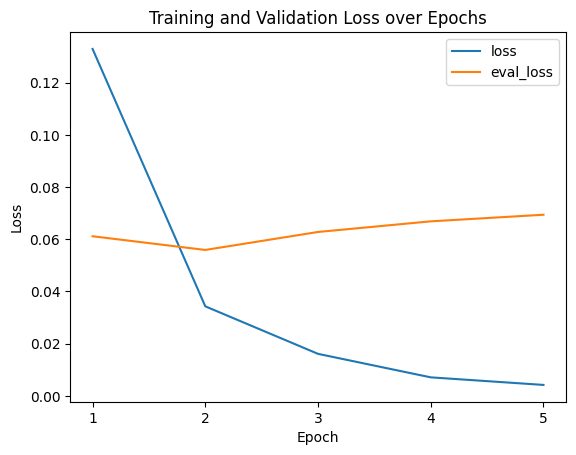

In [48]:
(
    logs[["loss", "eval_loss", "epoch"]]
    .plot(
        kind="line",
        x="epoch", 
        title="Training and Validation Loss over Epochs",
        xlabel="Epoch",
        ylabel="Loss",
        xticks=np.arange(1,6)
    )
)

<Axes: title={'center': 'Validation Metrics over Epochs'}, xlabel='Epoch', ylabel='Score'>

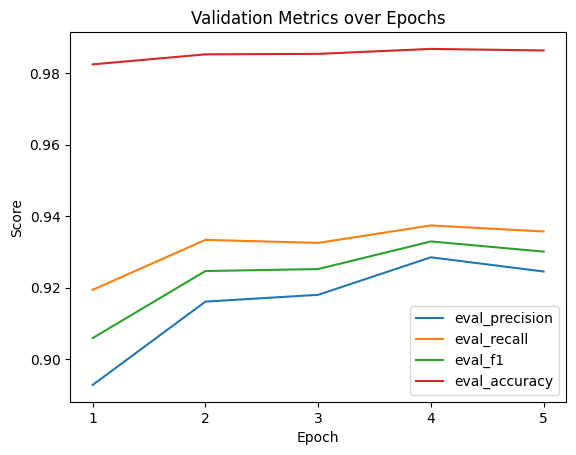

In [47]:
(
    logs[["epoch", "eval_precision", "eval_recall", "eval_f1", "eval_accuracy"]]
    .plot(
        kind="line",
        x="epoch",
        title="Validation Metrics over Epochs",
        xlabel="Epoch",
        ylabel="Score",
        xticks=np.arange(1,6)
    )
)

We'll go with epoch 2 as the metrics are perfectly high there and I want to avoid any potential overfitting from epochs 3 and on. Hard to gauge if it's genuinely overfitting due to the small number of epochs and how small all the loss scores are, but we'll play it safe. 

# Using the Model (Finally)

## Building the Pipeline

Pipelines are great when you can use them. Normally when you run predictions they're done on each and every token and require some cleanup, but pipelines handle prediction aggregation for you and provide some really clean output.

In [53]:
from transformers import pipeline

checkpoint = 1756 # Checkpoint for epoch 2.
model_dir = f"../models/holding_zone/checkpoint-{checkpoint}"
model = AutoModelForTokenClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)
aggregation_strategy = "average"
pipe = pipeline(
    task="token-classification", model=model, tokenizer=tokenizer, aggregation_strategy=aggregation_strategy
)

Here we'll run some predictions and add some extra information for context. The dictionaries at the bottom are the real output of the pipeline.

In [54]:
for index, row in enumerate(tokenized_ds["test"]):
    if index < 5:
        text = " ".join(row["tokens"])
        othertags = [id2label[id] for id in row["ner_tags"]]
        pipe_output = pipe(text)
        print(f"Row: {index}")
        print(f"Transaction: {text}")
        print(f"Actual NER tags: {othertags}")
        for output in pipe_output:
            print(output)
        print("\n")

Row: 0
Transaction: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Actual NER tags: ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O']
{'entity_group': 'LOC', 'score': 0.99867, 'word': 'japan', 'start': 9, 'end': 14}
{'entity_group': 'LOC', 'score': 0.99866974, 'word': 'china', 'start': 31, 'end': 36}


Row: 1
Transaction: Nadim Ladki
Actual NER tags: ['B-PER', 'I-PER']
{'entity_group': 'PER', 'score': 0.89792097, 'word': 'nadim ladki', 'start': 0, 'end': 11}


Row: 2
Transaction: AL-AIN , United Arab Emirates 1996-12-06
Actual NER tags: ['B-LOC', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O']
{'entity_group': 'LOC', 'score': 0.95205337, 'word': 'al - ain', 'start': 0, 'end': 6}
{'entity_group': 'LOC', 'score': 0.99500734, 'word': 'united arab emirates', 'start': 9, 'end': 29}


Row: 3
Transaction: Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
Actual NER tags: ['B-LOC', 'O', 'O', 'O', '

# Test Evaluation

In [55]:
from evaluate import evaluator

task_evaluator = evaluator("token-classification")
pipe = pipeline(
    task="token-classification", model=model, tokenizer=tokenizer
)

results = task_evaluator.compute(
    model_or_pipeline=pipe,
    data=tokenized_ds["test"],
    metric="seqeval",
    input_column="tokens",
    label_column="ner_tags",
    join_by=" "
)
results

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

{'LOC': {'precision': 0.9088182363527294,
  'recall': 0.908273381294964,
  'f1': 0.9085457271364317,
  'number': 1668},
 'MISC': {'precision': 0.7337837837837838,
  'recall': 0.7735042735042735,
  'f1': 0.753120665742025,
  'number': 702},
 'ORG': {'precision': 0.8,
  'recall': 0.8741721854304636,
  'f1': 0.8354430379746836,
  'number': 1661},
 'PER': {'precision': 0.9592986850344396,
  'recall': 0.9474335188620903,
  'f1': 0.9533291848164281,
  'number': 1617},
 'overall_precision': 0.8664719023887266,
 'overall_recall': 0.8927053824362606,
 'overall_f1': 0.8793930408999738,
 'overall_accuracy': 0.9754926240982018,
 'total_time_in_seconds': 85.87057160699987,
 'samples_per_second': 40.21168061863144,
 'latency_in_seconds': 0.024868396063423073}

This is a lot to take in, let me clean this up a bit so we can create some visualizations here.

In [68]:
overall_metrics = { 
    "OVERALL": {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "number": np.NaN
    }
}

keys_to_keep = ["LOC", "MISC", "ORG", "PER"]
metrics = {key: results[key] for key in keys_to_keep if key in results}
metrics.update(overall_metrics)
metrics

{'LOC': {'precision': 0.9088182363527294,
  'recall': 0.908273381294964,
  'f1': 0.9085457271364317,
  'number': 1668},
 'MISC': {'precision': 0.7337837837837838,
  'recall': 0.7735042735042735,
  'f1': 0.753120665742025,
  'number': 702},
 'ORG': {'precision': 0.8,
  'recall': 0.8741721854304636,
  'f1': 0.8354430379746836,
  'number': 1661},
 'PER': {'precision': 0.9592986850344396,
  'recall': 0.9474335188620903,
  'f1': 0.9533291848164281,
  'number': 1617},
 'OVERALL': {'precision': 0.8664719023887266,
  'recall': 0.8927053824362606,
  'f1': 0.8793930408999738,
  'number': nan}}

In [81]:
metric_df = (
    pd.DataFrame(metrics)
    .transpose()
)
metric_df

,precision,recall,f1,number
LOC,0.908818,0.908273,0.908546,1668.0
MISC,0.733784,0.773504,0.753121,702.0
ORG,0.800000,0.874172,0.835443,1661.0
PER,0.959299,0.947434,0.953329,1617.0
OVERALL,0.866472,0.892705,0.879393,NaN


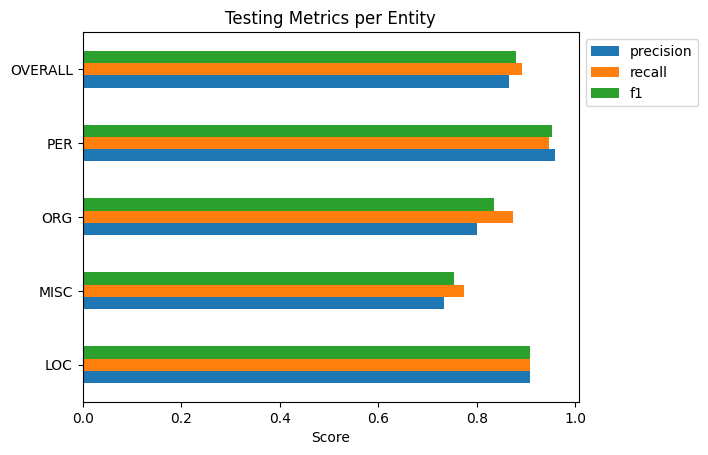

In [84]:
(
    metric_df
    .drop(["number"], axis=1)
    .plot(
        kind="barh",
        title="Testing Metrics per Entity",
        xlabel="Score"
    )
    .legend(bbox_to_anchor=(1,1))
)

<Axes: title={'center': 'Frequency of each Entity'}>

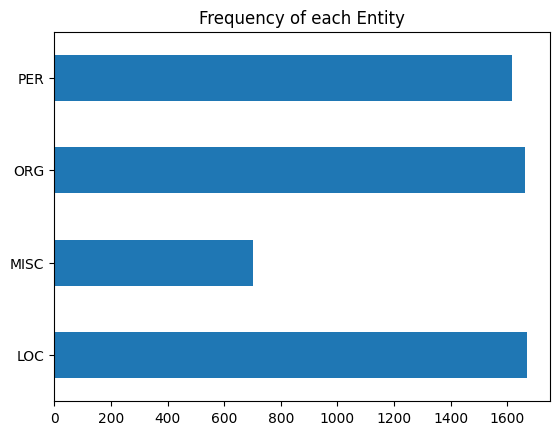

In [89]:
(
    metric_df["number"]
    .drop('OVERALL')
    .plot(
        kind="barh",
        title="Frequency of each Entity"
    )
)

# Conclusion

I hope this notebook provides a good reference for future use. We went through every step from loading in the data to evaluating a model against the testing split. There is some information this can't provide, such as manipulating data in a different format into a dataset object, but that'll just have to be a different tutorial for another time!  